## Importing the Necessary Libraries

In [1]:
# importing the standard libraries
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from types import SimpleNamespace
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

# importing pytorch libraries
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import transforms
import torch
import torch.nn as nn
from torchvision import models

## Step 1: Prepare and Explore Data

In [2]:
"""
First things first, to solve a multi-class problem (i.e. 1 output with multiple classes/unique values),
we want to make sure that for each plant folder in the 'plant_image_data folder', there is at least more than 1 image.
So to make sure the model performance is high, we only keep plant folders that have more than 5 images in the folder.
"""

image_root_dir = os.path.join(os.getcwd(), "plant_image_data")
image_root_dir


'/Users/peterchettiar/Library/CloudStorage/GoogleDrive-peterchet420@gmail.com/My Drive/Github-Repos/plant-image-classifier/plant_image_data'

In [3]:
# helper function to help count the number of images in each plant folder

def image_count(directory:str) -> int:
    image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tif", ".tiff"]
    image_count = 0
    for item in os.listdir(directory):
        if any(item.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

In [4]:
# only keep legitmate folder (e.g. of illegitamate folder is .DStore) and folder that contain more than 5 images

plant_folders = [subfolder for subfolder in os.listdir(image_root_dir) if not subfolder.startswith(".") and\
                 image_count(os.path.join(image_root_dir,subfolder)) > 5]

plant_folders

['Purple Donkey Orchid',
 'Eastern Black Nightshade',
 'Long-leaved Box',
 'Northern Coralroot',
 'Tridax Daisy',
 'American Beautyberry',
 'Common Reed',
 'Climbing Fig',
 'Legumes',
 'Red Clover',
 'Coast Seacoral',
 'Daylilies and Allies',
 'American Persimmon',
 'Common Milkweed',
 'White Heath Aster',
 'Crofton Weed',
 'Tawa',
 'Virginia Creeper',
 'Pinesap',
 'Thyme Pink-Bells',
 'Fen Grass of Parnassus',
 'Sacred Datura',
 'Witch Grass',
 'Diamond Spider Orchid',
 "Goldie's Wood Fern",
 "Giant Devil's-Fig",
 'Eastern Poison Ivy',
 'Sensitive Fern',
 'Arrow Bamboo',
 'Peruvian Zinnia',
 'Forest Red Gum',
 'Oriental Bittersweet',
 'Staghorn Sumac',
 'White Oak',
 'American Pokeweed',
 'Common Toadflax',
 'Catclaw Vine',
 'Osage-Orange',
 'Christmas Fern',
 'Littlebell',
 'Russian Olive',
 'Common Bird-Orchid',
 'Low Smartweed',
 'Madder Family']

In [5]:
# function to create the file path to each plant image, as well as enumerating the plant name
def label_image_files(label: int, folder_name: str) -> pd.DataFrame():
    
    # listing the images in the path of folder name
    folder_items = os.listdir(os.path.join(image_root_dir, folder_name))

    # next, we want to convert them into a df
    folder_items_df = pd.DataFrame(folder_items, columns=['file_name'])

    # we would need to add the folder name into filename - easier when loading the data later
    folder_items_df['file_name'] = folder_items_df['file_name'].apply(lambda x: f'{folder_name}/' + x)

    # create a column that enumerates the plant name
    folder_items_df['label'] = label

    return folder_items_df

In [6]:
# lets create a df containing the file paths to each image as well as a label for classification
image_path_label_list = []

for label, folder_name in enumerate(plant_folders):
    image_path_label_list.append(label_image_files(label, folder_name))

image_path_label_df = pd.concat(image_path_label_list, axis=0, ignore_index=True)
# removing unwanted file paths
image_path_label_df = image_path_label_df[~image_path_label_df.file_name.str.contains("DS_Store")]
image_path_label_df.reset_index(drop=True, inplace=True)
image_path_label_df

,file_name,label
0,Purple Donkey Orchid/328064892.jpg,0
1,Purple Donkey Orchid/328064922.jpg,0
2,Purple Donkey Orchid/328054215.jpg,0
3,Purple Donkey Orchid/328061793.jpg,0
4,Purple Donkey Orchid/328061801.jpg,0
...,...,...
336,Madder Family/328084157.jpg,43
337,Madder Family/328083118.jpg,43
338,Madder Family/328084164.jpg,43
339,Madder Family/328083814.jpg,43


In [7]:
# creating a list to reference enumerated labels to plant names

class_names = image_path_label_df.copy()
class_names['plant_name'] = class_names['file_name'].str.split("/", expand=True)[0]
class_names.drop(columns="file_name", inplace=True)
class_names = class_names.set_index('label').drop_duplicates().values.tolist()
class_names = [item for sublist in class_names for item in sublist]

<Axes: xlabel='label'>

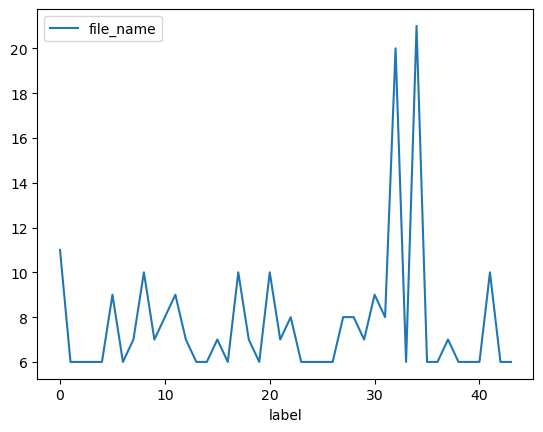

In [8]:
# good to do a count plot to see the number of images each plant folder / label has

image_path_label_df.groupby('label').count().plot()

In [9]:
# plant with the most images in its folder - clearly its the American Pokweed
max_label =  image_path_label_df['label'].value_counts().idxmax()

image_path_label_df[image_path_label_df['label'] == max_label]

,file_name,label
261,American Pokeweed/328085502.jpg,34
262,American Pokeweed/328067424.jpg,34
263,American Pokeweed/328066300.jpg,34
264,American Pokeweed/328062358.jpg,34
265,American Pokeweed/328064063.jpg,34
266,American Pokeweed/328068467.jpg,34
267,American Pokeweed/328070767.jpg,34
268,American Pokeweed/328066273.jpg,34
269,American Pokeweed/328069196.jpg,34
270,American Pokeweed/328068563.jpg,34


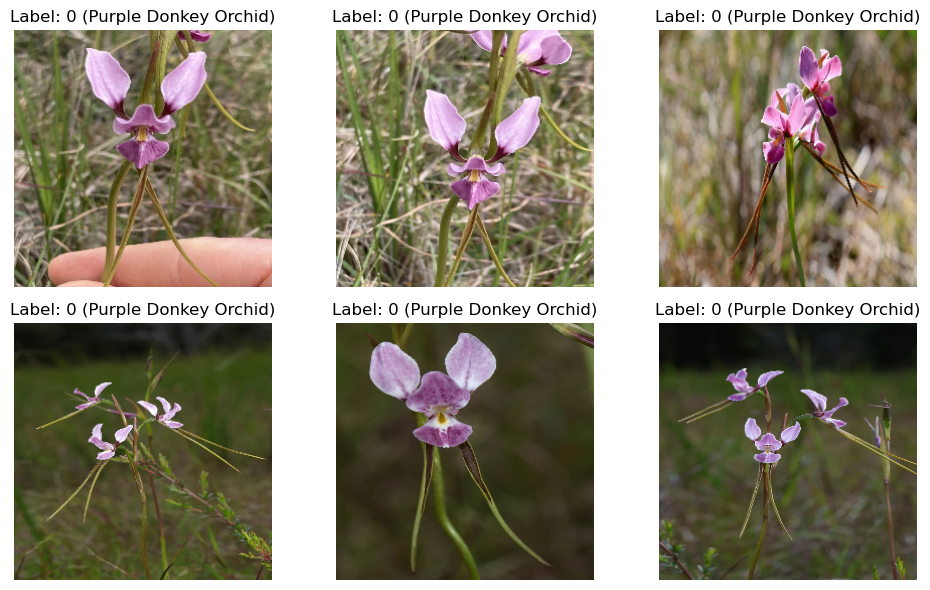

In [10]:
# To get a feeling for the dataset, it is always a good idea to plot a few samples

fig, ax = plt.subplots(2, 3, figsize=(10, 6))

idx = 0
for i in range(2):
    for j in range(3):
        
        label = image_path_label_df.label[idx]
        file_path = os.path.join(image_root_dir, image_path_label_df.file_name[idx])
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize image
        image = cv2.resize(image, (256, 256))

        plant_name = image_path_label_df.file_name[idx].split("/")[0]
        
        ax[i,j].imshow(image)
        ax[i,j].set_title(f"Label: {label} ({plant_name})")
        ax[i,j].axis('off')
        idx = idx+1
        
plt.tight_layout()
plt.show()

In [11]:
image[0][0]

array([10, 12, 11], dtype=uint8)

In [12]:
# before proceeding building the data pipeline, lets do the train test split

train_df, test_df = train_test_split(image_path_label_df,
                                     test_size= 0.2,
                                     random_state= 42)

## Step 2: Building a Baseline

### 2.1 A data pipeline for loading images

In [13]:
# but before we proceed, lets instantiate a config object to hold our parameters - useful 
# for any hyper parameter tuning down the line

config = SimpleNamespace()

# setting some basic configs
config.root_dir = image_root_dir
config.image_size = 256
config.normalise_mean = [0.485, 0.456, 0.406]
config.normalise_std = [0.229, 0.224, 0.225]
config.batch_size = 4


In [14]:
# we start by creating our custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform

    # returns the number of samples in our dataset
    def __len__(self):
        return len(self.img_labels)
    
    # constructor loads and returns a sample image (literally one image) from the dataset
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[index, 1]

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [15]:
# now we need to initialise a transformation pipeline for data augmentation - lets do one for train, test and validation

image_transforms = {
    'train': transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config.image_size, config.image_size)),  # Resize to a larger dimension first
    transforms.RandomRotation(30),  # Apply random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomVerticalFlip(),  # Flip vertically
    transforms.ToTensor(),
    transforms.Normalize(mean=config.normalise_mean, std=config.normalise_std) # Need to find the right values
    ]),

    'valid': transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config.image_size, config.image_size)),  # Resize to a larger dimension first
    transforms.CenterCrop(size=224),
    transforms.RandomVerticalFlip(),  # Flip vertically
    transforms.ToTensor(),
    transforms.Normalize(mean=config.normalise_mean, std=config.normalise_std)
    ]),  # Need to find the right values 

    'test': transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config.image_size, config.image_size)),  # Resize to a larger dimension first
    transforms.RandomRotation(10),  # Apply random rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=config.normalise_mean, std=config.normalise_std)
    ])  # Need to find the right values 
}

#### Note: 
The Dataloader returns the image batch and a label batch. The image_batch is a tensor of the shape (4, 3, 256, 256). This is a batch of 4 (batch_size) images with the shape (3, 256, 256) (color_channels, image_height, image_width). The label_batch is a tensor of the shape (4). These are the corresponding labels to the 4 images.

In [16]:
# to avoid overfitting, let’s randomly partition the training data into training and validation sets

X = train_df
y = train_df.label

train_df, valid_df, y_train, y_test = train_test_split(X, 
                                                       y, 
                                                       test_size = 0.2, 
                                                       random_state = 42)

train_df

,file_name,label
297,Osage-Orange/328057942.jpg,37
200,Sensitive Fern/328074183.jpg,27
247,Staghorn Sumac/328060844.jpg,32
14,Eastern Black Nightshade/328070695.jpg,1
175,Diamond Spider Orchid/328063106.jpg,23
...,...,...
230,Oriental Bittersweet/328065640.jpg,31
181,Goldie's Wood Fern/328073039.jpg,24
164,Witch Grass/328088123.jpg,22
270,American Pokeweed/328068563.jpg,34


In [17]:
# with this split, we can now create Datasets and Dataloaders for the training and validation data

train_dataset = CustomImageDataset(img_labels=train_df,
                                   img_dir=config.root_dir,
                                   transform=image_transforms['train'])

valid_dataset = CustomImageDataset(img_labels=valid_df,
                                   img_dir=config.root_dir,
                                   transform=image_transforms['valid'])

train_dataloader = DataLoader(train_dataset,
                              batch_size=config.batch_size,
                              shuffle=True,
                              num_workers=0)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=config.batch_size,
                              shuffle=False,
                              num_workers=0)

In [18]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = config.normalise_mean
    std = config.normalise_std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([4, 3, 256, 256]) tensor([34, 25, 20, 34])


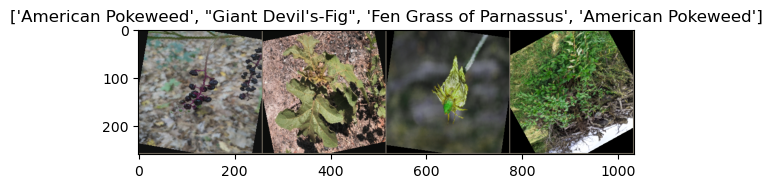

In [19]:
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
print(inputs.shape, classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2.2 Prepare the Model

In [20]:
config.n_classes = image_path_label_df.label.nunique()

### CovNet as fixed feature extractor - freeze all the network except the final layer, so that the gradients are not computed in backward()

In [21]:
# use gpu if available - training is faster 

config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
# Load a pretrained model and reset final fully connected layer.
model = models.resnet50(pretrained=True)

# Freezing the weights during transfer learning - we only want to train the last layer (feature extractor)
for param in model.parameters():
    param.requires_grad = False

# Modify the last few layers to match your requirements
num_ftrs = model.fc.in_features  # Get the number of input features to the last fully connected layer

# Replace the last fully connected layer with a new one
model.fc = torch.nn.Linear(num_ftrs, config.n_classes)

model = model.to(config.device)

### 2.3 Setting up loss function, optimizer and learning rate scheduler

In [23]:
# loss function - selected loss function is ideal for a multi-class problem
config.criterion = nn.CrossEntropyLoss()
config.learning_rate = 0.001
config.lr_min = 0.0001
config.epochs = 5

# for the optimizer, lets use adam as it is really popular and has faster convergence than SGD
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=0
)

# we would also need a learning rate scheduler - its purpose is to automatically modify the learning rate according to
# pre-defined schedule or rule, aiming to improve convergence and generalization of the model

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=np.ceil(len(train_dataloader.dataset) / config.batch_size) * config.epochs,
    eta_min=config.lr_min
)   # recommended lr scheduler for fine-tuning

### 2.4 Setup a training pipeline

#### 2.4.1 Train One Epoch

In [24]:
def train_one_epoch(train_dataloader, model, optimizer, scheduler, config):

    # training mode
    model.train()

    # initialising some useful variables
    running_loss = 0.0
    running_corrects = 0

    # iterate over data
    for data in tqdm(train_dataloader):
        # every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(config.device)
        labels = labels.to(config.device)

        # zero your gradients for every batch
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(True):
            # forward: make predictions for this input batch
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # forward: compute the loss and its gradients
            loss = config.criterion(outputs, labels)
            loss.backward()  # calculates the backward gradients over the learning weights

            # adjust the learning weights
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0) # loss.item() returns average loss per batch of 4
        running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)

    return epoch_acc, epoch_loss   

#### 2.4.2 Validate One Epoch

In [25]:
def validate_one_epoch(valid_dataloader, model, config):

    # set model to evaluation mode
    model.eval()

    # pretty much initialising the same variables as the train epoch function
    running_loss = 0.0
    running_corrects = 0

    # iterate over data
    for data in tqdm(valid_dataloader):
        # every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(config.device)
        labels = labels.to(config.device)

        with torch.no_grad(): # we are now using the gradients from training to validate model
            # Forward: Get model outputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Forward: Calculate loss
            loss = config.criterion(outputs, labels)

         # statistics
        running_loss += loss.item() * inputs.size(0) # loss.item() returns average loss per batch of 4
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(valid_dataset)
    epoch_acc = running_corrects / len(valid_dataset)

    return epoch_acc, epoch_loss

#### 2.4.3 Fit function - bringing them all together!

In [26]:
def fit(model, optimizer, scheduler, config, train_dataloader, valid_dataloader):
    # initialising some variables
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(config.epochs):
        print(f"Epoch {epoch + 1}/{config.epochs}")

        train_acc, train_loss = train_one_epoch(train_dataloader, model, optimizer, scheduler, config)

        val_acc, val_loss = validate_one_epoch(valid_dataloader, model, config)

        print(f'Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    return train_acc_list, train_loss_list, val_acc_list, val_loss_list, model



In [27]:
baseline_output = fit(model, optimizer, scheduler, config, train_dataloader, valid_dataloader)

Epoch 1/5


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Loss: 4.9169 Acc: 0.0323
Val Loss: 4.3683 Val Acc: 0.1091
Epoch 2/5


100%|██████████| 14/14 [00:02<00:00,  6.43it/s]


Loss: 3.8714 Acc: 0.0645
Val Loss: 3.9126 Val Acc: 0.1273
Epoch 3/5


100%|██████████| 14/14 [00:02<00:00,  6.46it/s]


Loss: 3.4484 Acc: 0.1336
Val Loss: 3.3942 Val Acc: 0.1636
Epoch 4/5


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Loss: 3.0227 Acc: 0.2903
Val Loss: 3.2784 Val Acc: 0.1636
Epoch 5/5


100%|██████████| 14/14 [00:02<00:00,  6.06it/s]

Loss: 2.8703 Acc: 0.3041
Val Loss: 3.2466 Val Acc: 0.1455


In [28]:
baseline_df = pd.DataFrame(baseline_output[:-1]).T
baseline_df.columns = [x for x in ["train_acc_list", "train_loss_list", "val_acc_list", "val_loss_list"]]
baseline_df

,train_acc_list,train_loss_list,val_acc_list,val_loss_list
0,tensor(0.0323),4.916884,tensor(0.1091),4.368346
1,tensor(0.0645),3.871386,tensor(0.1273),3.912623
2,tensor(0.1336),3.448351,tensor(0.1636),3.394221
3,tensor(0.2903),3.022653,tensor(0.1636),3.278369
4,tensor(0.3041),2.870336,tensor(0.1455),3.246591


## Step 3: Cross-Validation to improve accuracy 

We need to take this step given that our sample dataset is small, hence the poor accuracy of the baseline model.

In [29]:
config.n_folds = 5

# create a new column for cross-validation folds
image_path_label_df["kfold"] = -1

# initialise the kfold class
skf = StratifiedKFold(n_splits=config.n_folds)

# fill the new column
for fold, (train_, val_) in enumerate(skf.split(X=image_path_label_df, y=image_path_label_df.label)):
    image_path_label_df.loc[val_, "kfold"] = fold

image_path_label_df.head(10)

,file_name,label,kfold
0,Purple Donkey Orchid/328064892.jpg,0,0
1,Purple Donkey Orchid/328064922.jpg,0,0
2,Purple Donkey Orchid/328054215.jpg,0,0
3,Purple Donkey Orchid/328061793.jpg,0,1
4,Purple Donkey Orchid/328061801.jpg,0,1
5,Purple Donkey Orchid/328061796.jpg,0,2
6,Purple Donkey Orchid/328064965.jpg,0,2
7,Purple Donkey Orchid/328061149.jpg,0,3
8,Purple Donkey Orchid/328054226.jpg,0,3
9,Purple Donkey Orchid/328062346.jpg,0,4


In [30]:
df, test_df = train_test_split(image_path_label_df,
                                     test_size= 0.2,
                                     random_state= 42)

In [31]:
# For visualization purposes, we will also create plots of the loss and accuracy on the training and validation sets

def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    ax[0].plot(range(len(loss)), loss,  color='darkgrey', label = 'train')
    ax[0].plot(range(len(val_loss)), val_loss,  color='cornflowerblue', label = 'valid')
    ax[0].set_title('Loss')
    
    ax[1].plot(range(len(acc)), acc,  color='darkgrey', label = 'train')
    ax[1].plot(range(len(val_acc)), val_acc,  color='cornflowerblue', label = 'valid')
    ax[1].set_title('Metric (Accuracy)')

    for i in range(2):
        ax[i].set_xlabel('Epochs')
        ax[i].legend(loc="upper right")
    plt.show()

Epoch 1/5


100%|██████████| 15/15 [00:02<00:00,  6.28it/s]


Loss: 2.9459 Acc: 0.3070
Val Loss: 2.4271 Val Acc: 0.4386
Epoch 2/5


100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


Loss: 2.9271 Acc: 0.2884
Val Loss: 2.4377 Val Acc: 0.4912
Epoch 3/5


100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


Loss: 3.0361 Acc: 0.2419
Val Loss: 2.5242 Val Acc: 0.3333
Epoch 4/5


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


Loss: 3.0169 Acc: 0.2326
Val Loss: 2.3447 Val Acc: 0.4912
Epoch 5/5


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


Loss: 3.0080 Acc: 0.2465
Val Loss: 2.4327 Val Acc: 0.4561


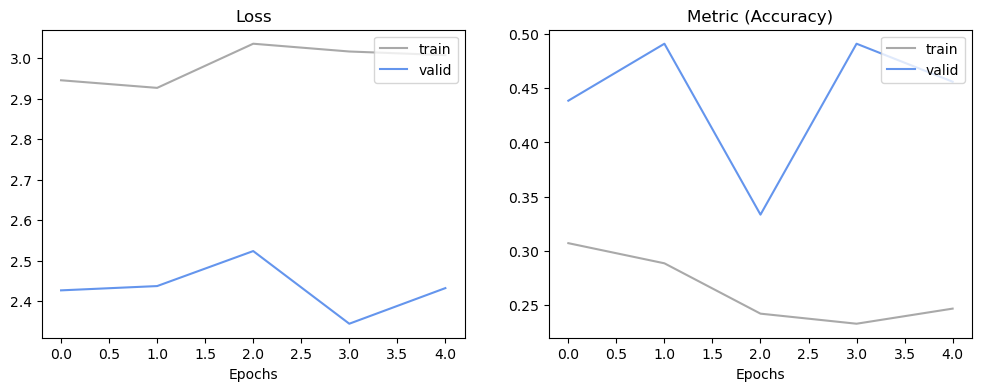

Epoch 1/5


100%|██████████| 13/13 [00:02<00:00,  6.02it/s]


Loss: 2.8829 Acc: 0.2818
Val Loss: 2.2039 Val Acc: 0.4038
Epoch 2/5


100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


Loss: 2.5622 Acc: 0.3500
Val Loss: 1.9069 Val Acc: 0.5000
Epoch 3/5


100%|██████████| 13/13 [00:02<00:00,  6.22it/s]


Loss: 2.1816 Acc: 0.4818
Val Loss: 1.6196 Val Acc: 0.5962
Epoch 4/5


100%|██████████| 13/13 [00:02<00:00,  6.07it/s]


Loss: 2.0393 Acc: 0.5136
Val Loss: 1.6334 Val Acc: 0.5385
Epoch 5/5


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


Loss: 1.7955 Acc: 0.6318
Val Loss: 1.6319 Val Acc: 0.5385


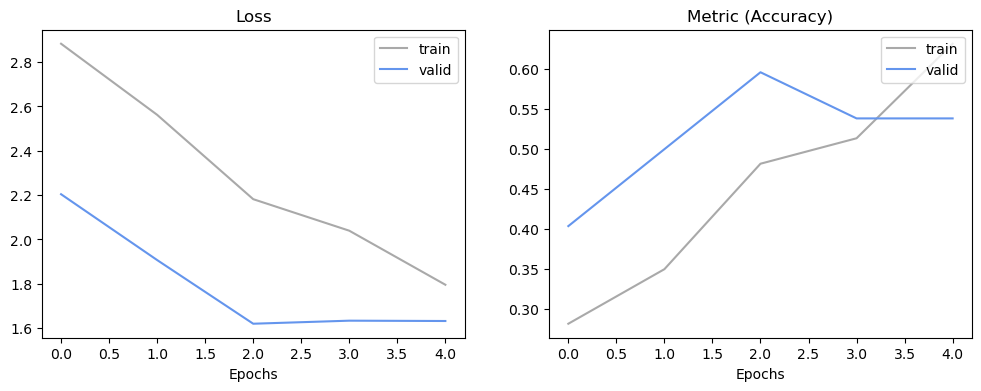

Epoch 1/5


100%|██████████| 14/14 [00:02<00:00,  6.32it/s]


Loss: 1.9264 Acc: 0.6055
Val Loss: 1.0746 Val Acc: 0.7593
Epoch 2/5


100%|██████████| 14/14 [00:02<00:00,  6.18it/s]


Loss: 1.9110 Acc: 0.6101
Val Loss: 1.0970 Val Acc: 0.7407
Epoch 3/5


100%|██████████| 14/14 [00:02<00:00,  6.34it/s]


Loss: 2.0868 Acc: 0.4725
Val Loss: 1.2402 Val Acc: 0.6481
Epoch 4/5


100%|██████████| 14/14 [00:02<00:00,  6.37it/s]


Loss: 2.0533 Acc: 0.4679
Val Loss: 1.3265 Val Acc: 0.7222
Epoch 5/5


100%|██████████| 14/14 [00:02<00:00,  6.38it/s]

Loss: 2.0434 Acc: 0.4633
Val Loss: 1.6739 Val Acc: 0.6111


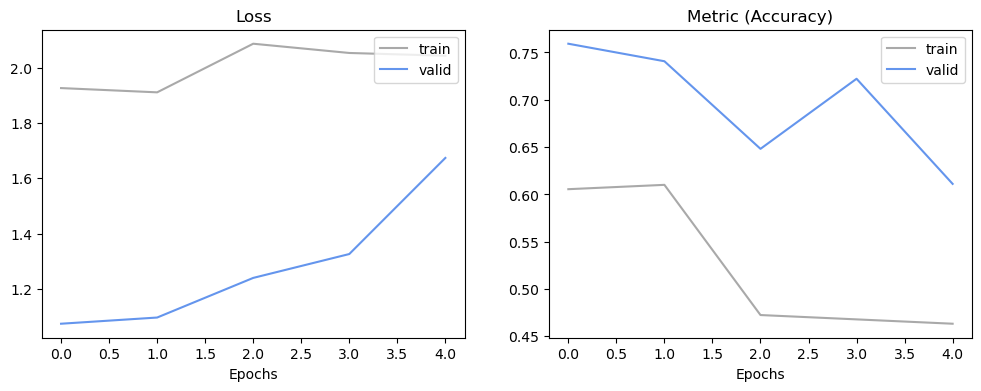

Epoch 1/5


100%|██████████| 15/15 [00:02<00:00,  6.11it/s]


Loss: 2.2048 Acc: 0.4198
Val Loss: 0.8505 Val Acc: 0.8000
Epoch 2/5


100%|██████████| 15/15 [00:02<00:00,  5.94it/s]


Loss: 1.9810 Acc: 0.4764
Val Loss: 1.0845 Val Acc: 0.6833
Epoch 3/5


100%|██████████| 15/15 [00:02<00:00,  6.11it/s]


Loss: 1.7035 Acc: 0.5708
Val Loss: 0.7021 Val Acc: 0.8000
Epoch 4/5


100%|██████████| 15/15 [00:02<00:00,  6.19it/s]


Loss: 1.6143 Acc: 0.6368
Val Loss: 0.5674 Val Acc: 0.9167
Epoch 5/5


100%|██████████| 15/15 [00:02<00:00,  5.45it/s]


Loss: 1.4131 Acc: 0.7123
Val Loss: 0.5296 Val Acc: 0.9167


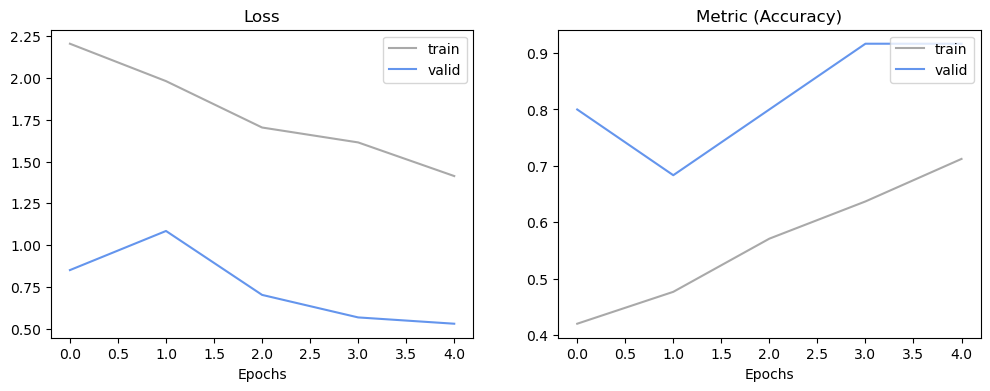

Epoch 1/5


100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


Loss: 1.3719 Acc: 0.7220
Val Loss: 0.4411 Val Acc: 0.9388
Epoch 2/5


100%|██████████| 13/13 [00:02<00:00,  5.87it/s]


Loss: 1.4860 Acc: 0.6906
Val Loss: 0.6019 Val Acc: 0.8571
Epoch 3/5


100%|██████████| 13/13 [00:02<00:00,  6.14it/s]


Loss: 1.6044 Acc: 0.6457
Val Loss: 0.6776 Val Acc: 0.8367
Epoch 4/5


100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


Loss: 1.7274 Acc: 0.5561
Val Loss: 0.7233 Val Acc: 0.8776
Epoch 5/5


100%|██████████| 13/13 [00:02<00:00,  5.75it/s]


Loss: 1.7738 Acc: 0.5426
Val Loss: 0.7950 Val Acc: 0.7959


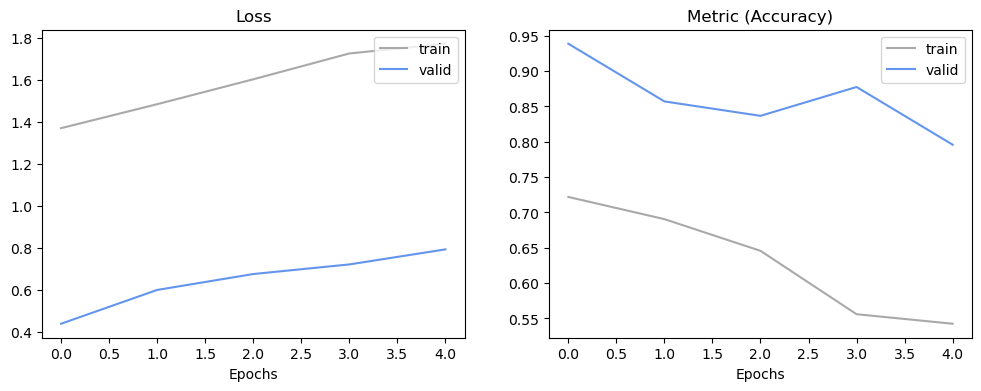

In [32]:
for fold in range(config.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = CustomImageDataset(img_labels=train_df,
                                    img_dir=config.root_dir,
                                    transform=image_transforms['train'])

    valid_dataset = CustomImageDataset(img_labels=valid_df,
                                    img_dir=config.root_dir,
                                    transform=image_transforms['valid'])

    train_dataloader = DataLoader(train_dataset,
                                batch_size=config.batch_size,
                                shuffle=True,
                                num_workers=0)

    valid_dataloader = DataLoader(valid_dataset,
                                batch_size=config.batch_size,
                                shuffle=False,
                                num_workers=0)
    
    acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, config, train_dataloader, valid_dataloader)
    
    visualize_history(acc, loss, val_acc, val_loss)

## Step 4: Let's checkout the accuracy on the test set

In [33]:

# this step should be fairly similar to validation df

test_dataset = CustomImageDataset(img_labels=test_df,
                                   img_dir=config.root_dir,
                                   transform=image_transforms['test'])

test_dataloader = DataLoader(test_dataset,
                              batch_size=config.batch_size,
                              shuffle=False,
                              num_workers=0)

In [34]:
# set model to evaluation mode
model.eval()

# pretty much initialising the same variables as the train epoch function
running_loss = 0.0
running_corrects = 0
predictions = []

# iterate over data
for data in tqdm(test_dataloader):
    # every data instance is an input + label pair
    inputs, labels = data
    inputs = inputs.to(config.device)
    labels = labels.to(config.device)

    with torch.no_grad(): # we are now using the gradients from training to validate model
        # Forward: Get model outputs
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.detach().cpu().numpy().tolist())

        # Forward: Calculate loss
        loss = config.criterion(outputs, labels)

        # statistics
    running_loss += loss.item() * inputs.size(0) # loss.item() returns average loss per batch of 4
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset)

100%|██████████| 18/18 [00:03<00:00,  4.61it/s]


In [35]:
test_df['predictions'] = predictions
test_df

,file_name,label,kfold,predictions
322,Common Bird-Orchid/328061564.jpg,41,1,3
116,Crofton Weed/328061306.jpg,15,4,4
113,Crofton Weed/328063341.jpg,15,1,4
42,American Beautyberry/328056231.jpg,5,3,17
126,Virginia Creeper/328060956.jpg,17,1,17
...,...,...,...,...
173,Diamond Spider Orchid/328063003.jpg,23,1,23
72,Red Clover/328057277.jpg,9,3,9
75,Coast Seacoral/328095003.jpg,10,0,4
16,Eastern Black Nightshade/328066929.jpg,1,4,17


In [36]:
print(epoch_loss,epoch_acc)

2.0750290207240893 tensor(0.4203)
